# **Example concentration-dependent GWP | Use case 3**

**Authors:**  
[Romain Sacchi](mailto:romain.sacchi@psi.ch)  
[Alvaro Hahn Menacho](mailto:alvaro.hahn-menacho@psi.ch)


This notebook presents an example to obtain an exchange-based LCA score using a parameterized approach to quantifying potential warming impacts of greenhouse gases.  
This example is part of the following publication:

**Sacchi, R., Menacho, A. H., Seitfudem, G., Agez, M., Schlesinger, J., Koyamparambath, A., Saldivar, J. S., Loubet, P., & Bauer, C.** (2025). *Contextual LCIA Without the Overhead: An Exchange-based Framework for Flexible Impact Assessment.*  
International Journal of Life Cycle Assessment.


## Structure

1. [Import *edges* and set *bw2 project*](#sec_import_edges)
2. [Import hydrogen production, PEM, LCI](#sec_import_h2)
3. [Select *Functional Unit* and *method*](#sec_select_fu)
4. [Run edges based LCA and export results](#sec_run_edges_lca)
6. [Plot results](#sec_plot_results)

<a id="sec_import_edges"></a>
# 1. Import edges and set bw2 project

In [1]:
from edges import EdgeLCIA, get_available_methods, setup_package_logging
import logging
import bw2data, bw2io

# we want the logger to log things into edges.log
#setup_package_logging(level=logging.INFO)
# if you want full debug:
setup_package_logging(level=logging.DEBUG)

/opt/homebrew/Caskroom/miniforge/base/envs/bw25/lib/python3.11/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__('pkg_resources').declare_namespace(__name__)


14:23:21+0200 [warning  ] Can't import `SimaProBlockCSVImporter` - please install `bw2io` with `pip install bw2io[multifunctional]` or install `multifunctional` and `bw_simapro_csv` manually.


For our example, we activate a ``brighway`` project that contains ecoinvent 3.10 cut-off.

In [2]:
bw2data.projects.set_current("bw25_ei310")

<a id="sec_import_h2"></a>
# 2. Import hydrogen production, PEM, LCI

To illustrate our water footprint case, we need to import some inventories representing the production of hydrogen using a PEM electrolyzer, powered with offshore wind power in France. The inventories are provided in this repository (``lci-hydrogen-electrolysis-ei310.xlsx``).

In [3]:
if "h2_pem" in bw2data.databases:
    del bw2data.databases["h2_pem"]
lci = bw2io.ExcelImporter("lci-hydrogen-electrolysis-ei310.xlsx")
lci.apply_strategies()
lci.match_database(fields=["name", "reference product", "location"])
lci.match_database("ecoinvent-3.10-cutoff",fields=["name", "reference product", "location"])
lci.match_database("biosphere",fields=["name", "categories"])
lci.statistics()
lci.drop_unlinked(i_am_reckless=True)
if len(list(lci.unlinked)) == 0:
    lci.write_database()

# we assign manually classifications to activities
# since it is unclear how to do that in the Excel inventory file.

classifications = {
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from grid electricity": ("CPC", "34210"),
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from solar photovoltaic electricity": ("CPC", "34210"),
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from onshore wind electricity": ("CPC", "34210"),
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from offshore wind electricity": ("CPC", "34210"),
    "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from geothermal electricity": ("CPC", "34210"),
    "electrolyzer production, 1MWe, PEM, Stack": ("CPC", "4220:Construction of utility projects"),
    "treatment of electrolyzer stack, 1MWe, PEM": ("CPC", "3830"),
    "electrolyzer production, 1MWe, PEM, Balance of Plant": ("CPC", "4220:Construction of utility projects"),
    "treatment of electrolyzer balance of plant, 1MWe, PEM": ("CPC", "3830"),
    "platinum group metal, extraction and refinery operations": ("CPC", "2420"),
    "deionized water production, via reverse osmosis, from brackish water": ("CPC", "34210")
}
for ds in bw2data.Database("h2_pem"):
    if ds["name"] in classifications:
        ds["classifications"] = [classifications[ds["name"]]]
        ds.save()

Extracted 1 worksheets in 0.04 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: normalize_units
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: assign_only_product_as_production
Applying strategy: link_technosphere_by_activity_hash
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 16 strategies in 0.06 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Graph statistics for `h2_pem` importer:
11 g

100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 817.73it/s]

14:10:48+0200 [info     ] Vacuuming database            


Created database: h2_pem


<a id="sec_select_fu"></a>
# 3. Select Functional Unit and method

### 3.1. Select FU
We select the activity to run the LCA for. In our case, it is the production of 1 kg of hydrogen, using a PEM electrolyzer, powered with offshore wind power, in France.

In [3]:
act = [a for a in bw2data.Database("h2_pem") if a["name"] == "hydrogen production, gaseous, 30 bar, from PEM electrolysis, from offshore wind electricity"][0]
act

'hydrogen production, gaseous, 30 bar, from PEM electrolysis, from offshore wind electricity' (kilogram, FR, None)

### 3.2. Select method

We first create a function that will claculate the GWP of a given over a given tine horizon.
Inspired from the IPCC AR5, 2021.

In [4]:
import numpy as np

In [5]:
# Physical constants
M_atm = 5.15e18  # kg, total mass of Earth's atmosphere
M_air = 28.96    # g/mol, average molar mass of air

# Gas-specific molecular weights (g/mol)
M_gas = {
    'CO2': 44.01,
    'CH4': 16.04,
    'N2O': 44.013
}

# IPCC concentration parameters (Myhre et al. 1998 / IPCC AR6)
RF_COEFF = {
    'CH4': 0.036,  # W·m⁻²·ppb⁻½ for CH4
    'N2O': 0.12    # W·m⁻²·ppb⁻½ for N2O
}

# Reference atmospheric concentrations (IPCC AR6, ~2019)
C_REF = {
    'CH4': 1866,  # ppb
    'N2O': 332    # ppb
}

# Indirect forcing factor for methane (IPCC AR6)
INDIRECT_FACTOR = {
    'CH4': 1.65,
    'N2O': 1.0
}

# Gas-specific atmospheric lifetimes (years, IPCC AR6)
TAU_GAS = {
    'CH4': 11.8,
    'N2O': 109
}

# CO2 impulse response function parameters (IPCC AR5/AR6)
CO2_IRF = {
    'a0': 0.2173,
    'a': [0.2240, 0.2824, 0.2763],
    'tau': [394.4, 36.54, 4.304]
}

# Convert concentration-based radiative efficiency to mass-based (W·m⁻²·kg⁻¹)
def convert_ppb_to_mass_rf(a_ppb, gas):
    return a_ppb * (M_atm / M_gas[gas]) * (M_air / 1e9)

# Calculate concentration-dependent radiative efficiency
def radiative_efficiency_concentration(gas, concentration_ppb):
    alpha = RF_COEFF[gas]
    return (alpha / (2 * np.sqrt(concentration_ppb))) * INDIRECT_FACTOR[gas]

# AGWP for CO2 (mass-based)
def AGWP_CO2(H):
    integral_CO2 = CO2_IRF['a0'] * H + sum(
        a * tau * (1 - np.exp(-H / tau))
        for a, tau in zip(CO2_IRF['a'], CO2_IRF['tau'])
    )
    am_CO2 = convert_ppb_to_mass_rf(1.37e-5, 'CO2')  # fixed IPCC radiative efficiency for CO2
    return am_CO2 * integral_CO2

# AGWP for gas at given concentration
def AGWP_gas(gas, H, concentration_ppb):
    aa_gas = radiative_efficiency_concentration(gas, concentration_ppb)
    am_gas = convert_ppb_to_mass_rf(aa_gas, gas)
    tau_gas = TAU_GAS[gas]
    return am_gas * tau_gas * (1 - np.exp(-H / tau_gas))

# Calculate concentration-dependent GWP
def GWP(gas, H, concentration_ppb):
    AGWP_g = AGWP_gas(gas, H, concentration_ppb)
    AGWP_ref = AGWP_CO2(H)
    return AGWP_g / AGWP_ref


In [6]:
GWP('CH4', 100, 1911)

30.660731597024444

In [7]:
# GWP and LCIA setup
allowed_funcs = {"GWP": GWP}
method = ('GWP', 'scenario-dependent', '100 years')

<a id="sec_run_edges_lca"></a>
# 4. Run edges-based LCA and export results

In [9]:
all_results = []  # To collect results

# Initialize LCIA
lcia = EdgeLCIA(
    demand={act: 1},
    filepath="lcia_parameterized_gwp.json", # we point to the json file containing the CFs definitions
    # scenario="RCP1.9",
    allowed_functions=allowed_funcs # we declare the functions to call.
)

# Usual LCIA steps
lcia.lci()
lcia.map_exchanges()

results = []
# Loop over scenarios
for scenario in [
    "RCP1.9",
    "RCP2.6",
    "RCP4.5",
    "RCP8.5",
]:
    for year in [
        "2020",
        "2050",
        "2080",
        "2100",
    ]:
        print(scenario, year)
        lcia.evaluate_cfs(scenario=scenario, scenario_idx=year)
        lcia.lcia()
        df = lcia.generate_cf_table()

        scenario_result = {
            "year": int(year),
            "rcp": scenario,
            "score": lcia.score,
            "CF_table": df
        }
        all_results.append(scenario_result)

        print(f"Year {year} | {scenario}: Impact = {lcia.score}")

/opt/homebrew/Caskroom/miniforge/base/envs/bw25/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 1.21e+13)
  warnings.warn(msg, UmfpackWarning)
Mapping exchanges: 100%|██████████████████████████| 3/3 [00:00<00:00, 27.23it/s]


RCP1.9 2020
Year 2020 | RCP1.9: Impact = 1.665470784049622
RCP1.9 2050
Year 2050 | RCP1.9: Impact = 1.6843722772231577
RCP1.9 2080
Year 2080 | RCP1.9: Impact = 1.7019090897709832
RCP1.9 2100
Year 2100 | RCP1.9: Impact = 1.711027669980119
RCP2.6 2020
Year 2020 | RCP2.6: Impact = 1.665470784049622
RCP2.6 2050
Year 2050 | RCP2.6: Impact = 1.6796253377026698
RCP2.6 2080
Year 2080 | RCP2.6: Impact = 1.6985112162317628
RCP2.6 2100
Year 2100 | RCP2.6: Impact = 1.7092842747067534
RCP4.5 2020
Year 2020 | RCP4.5: Impact = 1.665470784049622
RCP4.5 2050
Year 2050 | RCP4.5: Impact = 1.6589200762171388
RCP4.5 2080
Year 2080 | RCP4.5: Impact = 1.6667187377289479
RCP4.5 2100
Year 2100 | RCP4.5: Impact = 1.6704693410448874
RCP8.5 2020
Year 2020 | RCP8.5: Impact = 1.665470784049622
RCP8.5 2050
Year 2050 | RCP8.5: Impact = 1.6468493488085933
RCP8.5 2080
Year 2080 | RCP8.5: Impact = 1.641098726127663
RCP8.5 2100
Year 2100 | RCP8.5: Impact = 1.646063836291599


<a id="sec_plot_results"></a>
# 5. Plot results

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

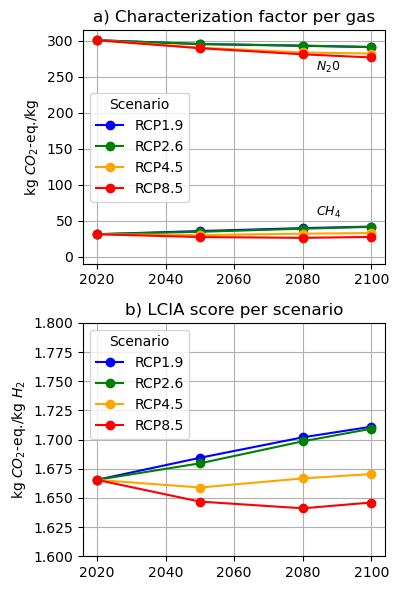

In [11]:
# Turn all_results into a DataFrame
df = pd.DataFrame(all_results)

# Make sure year is numeric
df["year"] = df["year"].astype(int)

# Set up subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 6), sharex=False)

# ---- Top plot: GWP factor per gas ----

# Gases to track
gases_of_interest = ["Carbon dioxide, fossil", "Methane, fossil", "Dinitrogen monoxide"]

# Colors per RCP
rcp_colors = {
    "RCP1.9": "blue",
    "RCP2.6": "green",
    "RCP4.5": "orange",
    #"RCP6.0": "orange",
    "RCP8.5": "red"
}

# Create empty dataframe to collect
gas_cf_data = []

# Loop over results
for res in all_results:
    year = res["year"]
    rcp = res["rcp"]
    cf_table = res["CF_table"]
    
    # Filter for only gases of interest
    cf_filtered = cf_table[cf_table["supplier name"].isin(gases_of_interest)]
    
    # For each gas separately
    for gas in gases_of_interest:
        cf_gas = cf_filtered[cf_filtered["supplier name"] == gas]
        if not cf_gas.empty:
            avg_cf = cf_gas["CF"].mean()
            gas_cf_data.append({
                "year": year,
                "rcp": rcp,
                "gas": gas,
                "avg_CF": avg_cf
            })

# Convert to DataFrame
df_gas_cf = pd.DataFrame(gas_cf_data)

# Plot: one line per gas and RCP, with RCP color
for gas in gases_of_interest:
    if gas == "Carbon dioxide, fossil":
        continue
    for rcp in df_gas_cf["rcp"].unique():
        df_plot = df_gas_cf[(df_gas_cf["gas"] == gas) & (df_gas_cf["rcp"] == rcp)]
        ax1.plot(df_plot["year"], df_plot["avg_CF"], marker='o', color=rcp_colors[rcp])

# ---- Add manual annotations for gases ----

# Pick a representative point for each gas (e.g., latest year, latest scenario)
for gas in gases_of_interest:
    df_gas = df_gas_cf[(df_gas_cf["gas"] == gas) & (df_gas_cf["rcp"] == "RCP8.5")]  # Pick RCP8.5 to annotate at right
    if not df_gas.empty:
        latest_point = df_gas[df_gas["year"] == df_gas["year"].max()]
        x = latest_point["year"].values[0]
        y = latest_point["avg_CF"].values[0]
        gas = gas.replace(", fossil", "")
        if gas=="Dinitrogen monoxide":
            gas = "$N_2$0"
            ax1.annotate(gas.replace(" ", "\n"), (x, y),
                         textcoords="offset points", xytext=(-40,-10), ha='left', fontsize=9)
        elif gas == "Methane":
            gas = "$CH_4$"
            ax1.annotate(gas.replace(" ", "\n"), (x, y),
                         textcoords="offset points", xytext=(-40,15), ha='left', fontsize=9)
        else:
            gas = "$CO_2$"
            #ax1.annotate(gas.replace(" ", "\n"), (x, y),
            #             textcoords="offset points", xytext=(-40,5), ha='left', fontsize=9)

# ---- Custom legend only for RCPs ----

custom_lines = [
    mlines.Line2D([], [], color="blue", marker='o', linestyle='-', label="RCP1.9"),
    mlines.Line2D([], [], color="green", marker='o', linestyle='-', label="RCP2.6"),
    mlines.Line2D([], [], color="orange", marker='o', linestyle='-', label="RCP4.5"),
    mlines.Line2D([], [], color="red", marker='o', linestyle='-', label="RCP8.5"),
]
ax1.legend(handles=custom_lines, title="Scenario", loc="center left")

ax1.set_title("a) Characterization factor per gas")
ax1.set_ylabel("kg $CO_2$-eq./kg")
ax1.grid(True)
ax1.set_ylim(bottom=-10)

# ---- Bottom plot: LCIA Scores ----

for rcp in df["rcp"].unique():
    df_rcp = df[df["rcp"] == rcp]
    ax2.plot(df_rcp["year"], df_rcp["score"], marker='o', color=rcp_colors[rcp], label=rcp)

ax2.set_title("b) LCIA score per scenario")
ax2.set_xlabel("")
ax2.set_ylabel("kg $CO_2$-eq./kg $H_2$")
ax2.set_ylim(1.6, 1.8)
ax2.grid(True)
ax2.legend(title="Scenario")

plt.tight_layout()
plt.savefig("figure_3.png", bbox_inches="tight", dpi=150)
plt.show()